In [1]:
#dataframes
import pandas as pd
import h5py

#speedup
import multiprocessing as mp

#suppress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.TimeSeries = pd.Series 

#math
import numpy as np
import math
from scipy.spatial.distance import cdist
import statsmodels.api as sm
import statsmodels.formula.api as smf

#plots
import pylab as plt
import matplotlib.pyplot as plt
import matplotlib as mat
from mpl_toolkits.axes_grid1 import make_axes_locatable # for colorbar
import seaborn as sns
sns.set()
import figurefirst

#misc
import time
np.set_printoptions(suppress=True)


In [38]:
# set_number = 5
dir = '~/Documents/Myfiles/DataAnalysis/data/Sprints/HighRes/'
df = pd.read_hdf(dir+'Run01Run02Run03_Filtered.h5')
dir1 = '~/Documents/Myfiles/DataAnalysis/data/Sprints/LowRes/'
df2=pd.read_hdf(dir1+'NotWindyStats.h5')

In [43]:
df.drop(df.loc[(df['sync_time'] >= 3100) & (df['sync_time'] <= 5050)].index,inplace=True) 

In [54]:
len(df)

1289621

In [47]:
df.keys()

Index(['master_time', 'xsrc', 'ysrc', 'odor', 'trisonica_u', 'trisonica_v',
       'trisonica_pressure', 'trisonica_temperature', 'gps_linear_x',
       'gps_linear_y', 'gps_linear_z', 'imu_angular_x', 'imu_angular_y',
       'imu_angular_z', 'imu_linear_acc_x', 'imu_linear_acc_y',
       'imu_linear_acc_z', 'U', 'V', 'D', 'S2', 'mock',
       'distance_along_streakline', 'nearest_from_streakline',
       'distance_from_source', 'relative_motion', 'filtered_odor', 'time',
       'wind_direction'],
      dtype='object')

In [45]:
df.reset_index(inplace=True, drop=True) 

In [48]:
sync_time = df.master_time-df.master_time[0]
df.insert(1,'sync_time',sync_time)

In [42]:
# todo : change direction to -180 to 180
# change it to radians
# subtract from sensor direction

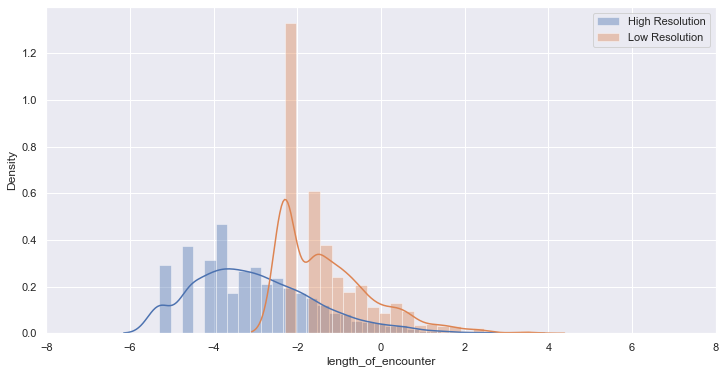

In [8]:
fig, ax = plt.subplots(figsize=(12,6))
ax = sns.distplot(np.log(df1['length_of_encounter']), label = 'High Resolution')
ax=sns.distplot(np.log(df2['length_of_encounter']), label = 'Low Resolution')
ax.set_xlim(-8, 8)
ax.legend()
# fig.savefig('../../Figure/distplot.jpeg')

In [55]:
df['time']=df.sync_time

In [57]:
## getting the indexes for odor over a threshold to determine each encounter
def get_index(df):
    idx = []
    for i in range(len(df.odor)):
        if (df.odor[i]>3):
            idx.append(df.index[i])

    from itertools import groupby
    from operator import itemgetter
    index = [ ]
    for k, g in groupby(enumerate(idx),lambda ix : ix[0] - ix[1]):
        index.append((list((map(itemgetter(1), g)))))
    return index

In [58]:
fdf=pd.DataFrame()
index = get_index(df)
        
i = 0
#to compare with R^2 analysis
avg_dist_from_source = []
while i<len(index):
    avg_dist_from_source.append(np.mean(df.distance_along_streakline[index[i]]))
    i+=1
fdf['avg_dist_along_streakline']=avg_dist_from_source


i=0
avg_dist_source = []
while i<len(index):
    avg_dist_source.append(np.mean(df.distance_from_source[index[i]]))
    i+=1
fdf['avg_dist_from_source']=avg_dist_source

avg_dist_from_streakline = []
i = 0
while i<len(index):
    avg_dist_from_streakline.append(np.mean(df.nearest_from_streakline[index[i]]))
    i+=1
fdf['avg_dist_from_streakline']=avg_dist_from_streakline


rel_motion_encounter = []
i= 0
while i<len(index):
    rel_motion_encounter.append(np.mean(df.relative_motion[index[i]]))
    i+=1
fdf['streakline_relative_motion_encounter']=rel_motion_encounter


rel_motion_intermittency = []
i= 0
while i < len(index):
    if i < (len(index)-1):
        rel_motion_intermittency.append(np.mean(df.relative_motion[index[i][-1]:index[i+1][0]]))
        i+=1
    else:
        rel_motion_intermittency.append(0)
        i+=1
        
fdf['streakline_relative_motion_intermittency']=rel_motion_intermittency

In [59]:
# mean odor concentration
i = 0
concentration = []
while i<len(index):
    concentration.append(np.mean(df.odor[index[i]]))
    i+=1
fdf['odor'] = concentration

# time of the encounters
i = 0
length_of_encounter = []
dt = df.time[1]-df.time[0]   ## dt is constant, dt * length gives length of time
while i < len(index):
    length_of_encounter.append(dt*(len(index[i])))
    i+=1
fdf['length_of_encounter'] = length_of_encounter

#time between the encounters
i = 0
intermittency = []
while i < len(index):
    if i < (len(index)-1):
        intermittency.append((index[i+1][0] - index[i][-1])*dt)
        i+=1
    else:
        intermittency.append(0)
        i+=1
fdf['odor_intermittency'] = intermittency

## Trajectory speed during Intermittency
i = 0
speed_at_intermittency=[]
while i < len(index):
    if i < (len(index)-1):
        x = np.mean(df.gps_linear_x[index[i][-1]:index[i+1][0]])
        y = np.mean(df.gps_linear_y[index[i][-1]:index[i+1][0]])
        z = np.mean(df.gps_linear_z[index[i][-1]:index[i+1][0]])
        speed_at_intermittency.append(np.sqrt(x**2+y**2+z**2))
        i+=1
    else:
        speed_at_intermittency.append(0)
        i+=1

fdf['speed_at_intermittency'] = speed_at_intermittency

## Trajectory speed during Encounters
i = 0
speed_at_encounter=[]
while i < len(index):
        x = np.mean(df.gps_linear_x[index[i]])
        y = np.mean(df.gps_linear_y[index[i]])
        z = np.mean(df.gps_linear_z[index[i]])
        speed_at_encounter.append(np.sqrt(x**2+y**2+z**2))
        i+=1
fdf['speed_at_encounter'] = speed_at_encounter



In [60]:
### Wind speed during encounter and Intermittency
i = 0
wind_speed_encounter = []
while i<len(index):
    wind_speed_encounter.append(np.mean(df.S2[index[i]]))
    i+=1
fdf['wind_speed_encounter'] = wind_speed_encounter

### Wind speed during intermittency
i = 0
wind_speed_intermittency = []
while i<len(index):
    if i < (len(index)-1):
        wind_speed_intermittency.append(np.mean(df.S2[index[i][-1]:index[i+1][0]]))
        i+=1
    else:
        wind_speed_intermittency.append(0)
        i+=1
fdf['wind_speed_intermittency'] = wind_speed_intermittency

In [33]:
angle=[]
for i in range(len(df)):
    if df.D[i]>180:
        angle.append(df.D[i]-360)
    else:
        angle.append(df.D[i])
        
df['wind_direction']=np.radians(angle)

In [61]:
### Wind Direction during Encounter and Intermittency

i = 0
relative_motion_to_wind_encounter=[]
while i<len(index):
    
    sensor_direction = (np.arctan2(np.mean(df.gps_linear_y[index[i]]),
                                           np.mean(df.gps_linear_x[index[i]])))
    wind_direction = np.array(np.mean(df.wind_direction[index[i]]))
        
    relative_motion_to_wind_encounter.append(sensor_direction - wind_direction)
    i+=1

fdf['relative_motion_to_wind_encounter']=relative_motion_to_wind_encounter


# #finding sensor motion relative to wind direction from stationery
i = 0
relative_motion_to_wind_intermittency=[]
while i<len(index):
    if i < (len(index)-1):
        sensor_direction = (np.arctan2(np.mean(df.gps_linear_y[index[i][-1]:index[i+1][0]]),
                                               np.mean(df.gps_linear_x[index[i][-1]:index[i+1][0]])))
        wind_direction = np.array(np.mean(df.wind_direction[index[i][-1]:index[i+1][0]]))

        relative_motion_to_wind_intermittency.append(sensor_direction - wind_direction)
        i+=1
    else:
        relative_motion_to_wind_intermittency.append(0)
        i+=1
fdf['relative_motion_to_wind_intermittency']=relative_motion_to_wind_intermittency

In [62]:
fdf.to_hdf(dir1+'NotWindyStatsFiltered.h5', key='fdf', mode='w')

In [63]:
dir = '~/Documents/Myfiles/DataAnalysis/data/Sprints/HighRes/'
df2 = pd.read_hdf(dir+'NotWindyStatsFiltered.h5')

In [64]:
df2.keys()

Index(['avg_dist_along_streakline', 'avg_dist_from_source',
       'avg_dist_from_streakline', 'streakline_relative_motion_encounter',
       'streakline_relative_motion_intermittency', 'odor',
       'length_of_encounter', 'odor_intermittency', 'speed_at_intermittency',
       'speed_at_encounter', 'wind_speed_encounter',
       'wind_speed_intermittency', 'relative_motion_to_wind_encounter',
       'relative_motion_to_wind_intermittency'],
      dtype='object')

/Users/an/Documents/MyFiles/DataAnalysis/FlyDataAnalysis/lib/python3.8/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


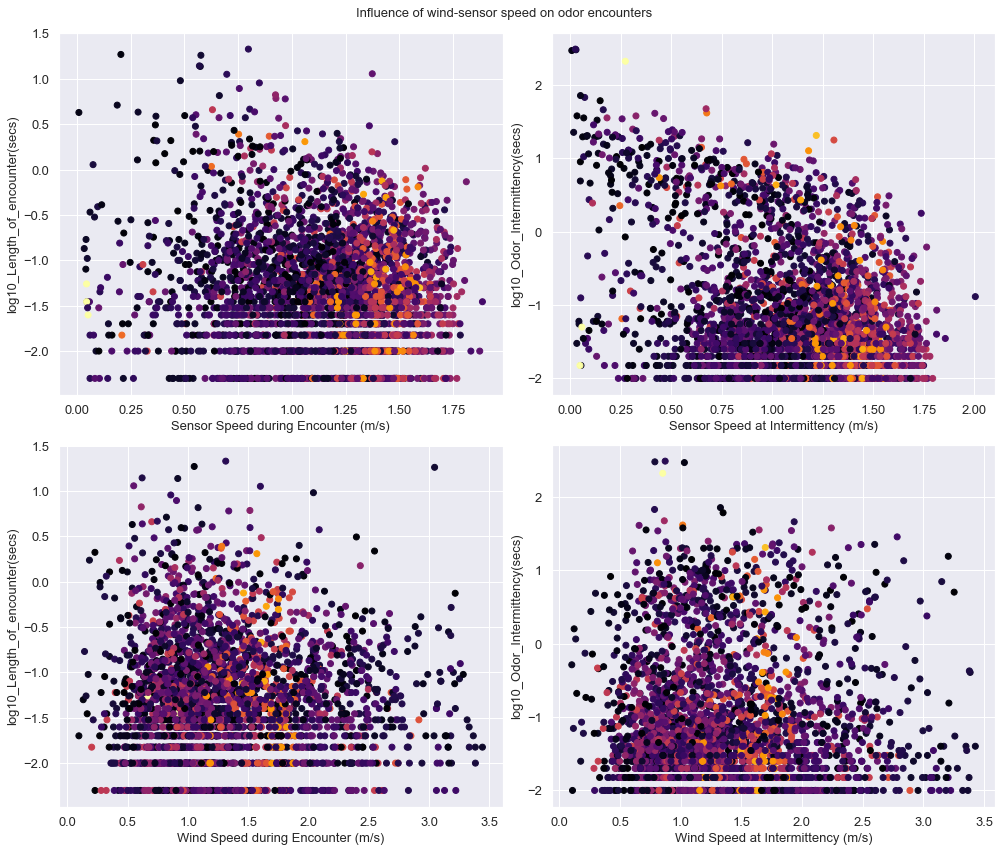

In [65]:
f, ((ax1,ax2), (ax3,ax4)) = plt.subplots(2,2, figsize =(14,12), 
                            gridspec_kw={'height_ratios':[3,3],'width_ratios': [4,4]})
f.suptitle('Influence of wind-sensor speed on odor encounters')
ax1.set_xlabel('Sensor Speed during Encounter (m/s)')
ax1.scatter(df2.speed_at_encounter, np.log10(df2.length_of_encounter), c=df2.avg_dist_from_source, cmap='inferno')
ax1.set_ylabel('log10_Length_of_encounter(secs)')

ax2.scatter(df2.speed_at_intermittency, np.log10(df2.odor_intermittency), c=df2.avg_dist_from_source, cmap='inferno')
ax2.set_xlabel('Sensor Speed at Intermittency (m/s)')
ax2.set_ylabel('log10_Odor_Intermittency(secs)')

ax3.set_xlabel('Wind Speed during Encounter (m/s)')
ax3.scatter(df2.wind_speed_encounter, np.log10(df2.length_of_encounter), c=df2.avg_dist_from_source, cmap='inferno')
ax3.set_ylabel('log10_Length_of_encounter(secs)')

ax4.scatter(df2.wind_speed_intermittency, np.log10(df2.odor_intermittency), c=df2.avg_dist_from_source, cmap='inferno')
ax4.set_xlabel('Wind Speed at Intermittency (m/s)')
ax4.set_ylabel('log10_Odor_Intermittency(secs)')

f.tight_layout()
figurefirst.mpl_functions.set_fontsize(f, 13)
f.savefig('../../Figure/speedvsencounter_notwindy4.jpeg')

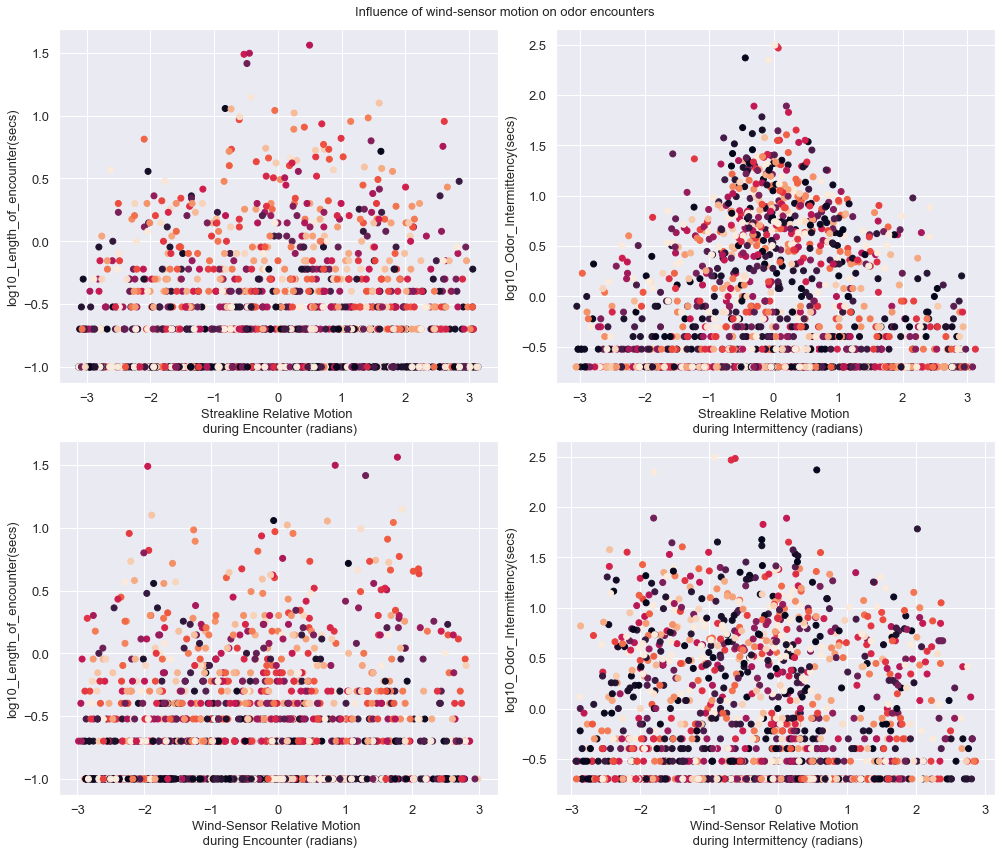

In [23]:
f, ((ax1,ax2), (ax3,ax4)) = plt.subplots(2,2, figsize =(14,12), 
                            gridspec_kw={'height_ratios':[3,3],'width_ratios': [4,4]})

f.suptitle('Influence of wind-sensor motion on odor encounters')
ax1.set_xlabel('Streakline Relative Motion \n during Encounter (radians)')
ax1.scatter(df2.streakline_relative_motion_encounter, np.log10(df2.length_of_encounter), c=df2.odor)
ax1.set_ylabel('log10_Length_of_encounter(secs)')

ax2.scatter(df2.streakline_relative_motion_intermittency, np.log10(df2.odor_intermittency), c=df2.odor)
ax2.set_xlabel('Streakline Relative Motion \n during Intermittency (radians)')
ax2.set_ylabel('log10_Odor_Intermittency(secs)')

ax3.scatter(df2.relative_motion_to_wind_encounter/2, np.log10(df2.length_of_encounter), c=df2.odor)
ax3.set_xlabel('Wind-Sensor Relative Motion \n during Encounter (radians)')
ax3.set_ylabel('log10_Length_of_encounter(secs)')

ax4.scatter(df2.relative_motion_to_wind_intermittency/2, np.log10(df2.odor_intermittency), c=df2.odor)
ax4.set_xlabel('Wind-Sensor Relative Motion \n during Intermittency (radians)')
ax4.set_ylabel('log10_Odor_Intermittency(secs)')


f.tight_layout()
figurefirst.mpl_functions.set_fontsize(f, 13)
# f.savefig('../../Figure/motionvsencounter_notwindyHD.jpeg')

In [61]:
## Normalization
# normalized_fdf=(fdf-fdf.mean())/fdf.std()

## mean max normalization
# normalized_fdf=(fdf-fdf.min())/(fdf.max()-fdf.min())
# fdf.to_hdf(dir+'WindyStats.h5', key='df', mode='w')

In [31]:
# odor_distance_model = smf.ols(formula='avg_dist_fromsource ~ odor + odor_intermittency + length_of_encounter + odor_stdev + tri_pressure + tri_temperature + linear_acc_x + linear_acc_y + linear_acc_z + imu_angular_x + imu_angular_y + imu_angular_z', data=fdf).fit()
encounters=smf.ols(formula='np.log10(length_of_encounter) ~ speed_at_encounter + streakline_relative_motion_encounter', data=df2).fit()
print(encounters.summary())

                                  OLS Regression Results                                 
Dep. Variable:     np.log10(length_of_encounter)   R-squared:                       0.060
Model:                                       OLS   Adj. R-squared:                  0.059
Method:                            Least Squares   F-statistic:                     42.11
Date:                           Thu, 12 Aug 2021   Prob (F-statistic):           1.87e-18
Time:                                   09:32:12   Log-Likelihood:                -869.79
No. Observations:                           1321   AIC:                             1746.
Df Residuals:                               1318   BIC:                             1761.
Df Model:                                      2                                         
Covariance Type:                       nonrobust                                         
                                           coef    std err          t      P>|t|      [0.025      0.

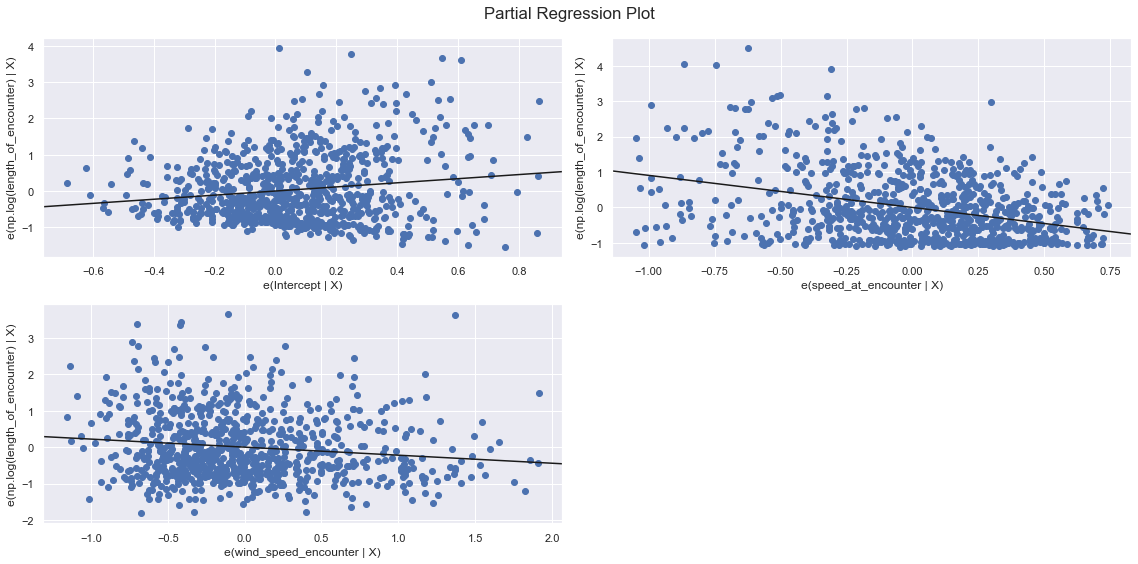

In [128]:
plt.rc("figure", figsize=(16,8))
plt.rc("font", size=14)
fig = sm.graphics.plot_partregress_grid(encounters)
fig.tight_layout(pad=1.0)
# fig.savefig('regressplot.jpeg')

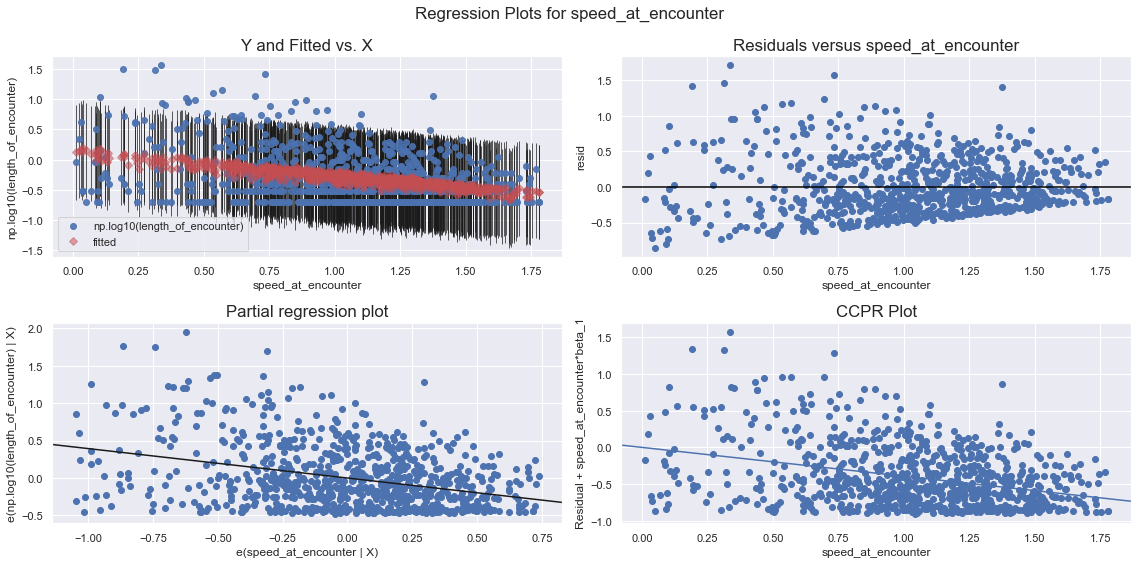

In [130]:
fig = sm.graphics.plot_regress_exog(encounters, "speed_at_encounter")
fig.tight_layout(pad=1.0)

### Finding odor encounter distance from source

In [ ]:
# df_pos['time'] = df_tmp['time']
# df_pos['distance']=hp.haversine_distance(df_tmp._ublox_gps_fix_latitude.astype(float),df_tmp._ublox_gps_fix_longitude.astype(float), 39.67650835454546,-119.82060767454543)
# df_pos['odor_concentration'] = df_tmp['_analog_output_data']

#### Not Required Stats

In [ ]:

## Odor Standard Deviation
i = 0
st_dev = []
while i<len(index):
    st_dev.append(np.std(df.odor[index[i]]))
    i+=1
fdf['odor_stdev'] = st_dev

## Trisonica Mean Pressure
i = 0
pressure = []
while i<len(index):
    pressure.append(np.mean(df.trisonica_pressure[index[i]]))
    i+=1
fdf['tri_pressure'] = pressure

## Trisonica Mean Temperature
i = 0
temperature = []
while i<len(index):
    temperature.append(np.mean(df.trisonica_temperature[index[i]]))
    i+=1
fdf['tri_temperature'] = temperature

## Trisonica Mean Linear acceleration
i = 0
linear_acc_x = []
while i<len(index):
    linear_acc_x.append(np.mean(df.imu_linear_acc_x[index[i]]))
    i+=1
fdf['linear_acc_x'] = linear_acc_x

i = 0
linear_acc_y = []
while i<len(index):
    linear_acc_y.append(np.mean(df.imu_linear_acc_y[index[i]]))
    i+=1
fdf['linear_acc_y'] = linear_acc_y

i = 0
linear_acc_z = []
while i<len(index):
    linear_acc_z.append(np.mean(df.imu_linear_acc_z[index[i]]))
    i+=1
fdf['linear_acc_z'] = linear_acc_z

## Trisonica Mean Angular vel
i = 0
angular_vel_x = []
while i<len(index):
    angular_vel_x.append(np.mean(df.imu_angular_x[index[i]]))
    i+=1
fdf['imu_angular_x'] = angular_vel_x

i = 0
angular_vel_y = []
while i<len(index):
    angular_vel_y.append(np.mean(df.imu_angular_y[index[i]]))
    i+=1
fdf['imu_angular_y'] = angular_vel_y

i = 0
angular_vel_z = []
while i<len(index):
    angular_vel_z.append(np.mean(df.imu_angular_z[index[i]]))
    i+=1
fdf['imu_angular_z'] = angular_vel_z